In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

SystemError: initialization of _internal failed without raising an exception

# Collecte des données 

Pour analyser, l'impact des taux d'intérêts dans chaque secteur de l'économie, nous allons utiliser des ETFs réplicants chacun des secteurs de l'économie américaine : 

Pour obtenir les tickers des ETFs (Exchange Traded Funds) qui représentent chacun de ces secteurs de l'économie américaine, on peut généralement se référer à des ETFs populaires qui sont largement utilisés pour suivre la performance de ces secteurs spécifiques.

1. **Finance** - Financial Select Sector SPDR Fund (`XLF`) : Axé sur le secteur financier, ce fonds inclut des institutions financières majeures comme Berkshire Hathaway et JPMorgan Chase. Il est sensible aux fluctuations des taux d'intérêt et des politiques monétaires.
2. **Medical** - Health Care Select Sector SPDR Fund (`XLV`) : Ce fonds se concentre sur le secteur de la santé, incluant des géants comme UnitedHealth et Pfizer. Il est relativement stable et peut bien performer en période de crise sanitaire.
3. **Computer and Technology** - Technology Select Sector SPDR Fund (`XLK`) : Inclut des leaders technologiques comme Apple et Microsoft. Fort potentiel de croissance mais sensible aux changements technologiques et aux régulations.
4. **Oils/Energy** - Energy Select Sector SPDR Fund (`XLE`) : Concentre sur les entreprises énergétiques telles qu'Exxon Mobil et Chevron. Très volatil, dépend des prix des matières premières et des politiques énergétiques.
5. **Retail/Wholesale** - SPDR S&P Retail ETF (`XRT`) : Représente le secteur de la vente au détail, incluant des entreprises comme Carvana et PDD Holdings. Affecté par les tendances de consommation et la santé économique globale.
6. **Consumer Staples** - Consumer Staples Select Sector SPDR Fund (`XLP`)  : Comprend des entreprises de biens de consommation courante comme Procter & Gamble et Coca-Cola. Stable et résilient en période de récession économique.
7. **Basic Materials** - Materials Select Sector SPDR Fund (`XLB`) : Se concentre sur les matériaux de base, incluant Linde et Sherwin-Williams. Volatil, dépend des prix des matières premières.
8. **Industrial Products** - Industrial Select Sector SPDR Fund (`XLI`) : Axé sur les produits industriels, incluant Raytheon et Honeywell. Influencé par les cycles économiques et les investissements en infrastructures.
9. **Utilities** - Utilities Select Sector SPDR Fund (`XLU`) : Concentre sur les services publics, incluant NextEra Energy et Duke Energy. Stable, souvent considéré comme un investissement défensif.
10. **Consumer Discretionary** - Consumer Discretionary Select Sector SPDR Fund (`XLY`) : Comprend des entreprises de biens de consommation discrétionnaires comme Amazon et Tesla. Volatil, dépend de la santé économique et du pouvoir d'achat des consommateurs.
11. **Transportation** - iShares Transportation Average ETF (`XTN`) : Représente le secteur des transports, incluant American Airlines et UPS. Affecté par les coûts des carburants et les tendances économiques globales.
13. **Aerospace** - iShares U.S. Aerospace & Defense ETF (`XAR`) :  Se concentre sur l'aérospatiale et la défense, incluant Boeing et Lockheed Martin. Sensible aux dépenses de défense et aux innovations technologiques.



Pour une analyse plus détaillé,nous pouvons regarder les parts de chaque secteur dans l'économie américaine qui peuvent être approximées en regardant leur poids dans les indices boursiers larges comme le S&P 500

tableau des parts approximatives de chaque secteur dans l'économie américaine :

| Sector                    | Approximate Share (%) |
|---------------------------|-----------------------|
| Finance                   | 12                    |
| Medical                   | 13.5                  |
| Computer and Technology   | 28                    |
| Oils/Energy               | 2.5                   |
| Retail/Wholesale          | 11                    |
| Consumer Staples          | 6.5                   |
| Basic Materials           | 2.5                   |
| Industrial Products       | 8.5                   |
| Utilities                 | 2.5                   |
| Consumer Discretionary    | 12.5                  |
| Transportation            | 2.5                   |
| Aerospace                 | 1.5       ndices boursiers.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1124 entries, 2019-12-31 to 2024-06-18
Data columns (total 12 columns):
 #   Column                   Non-Null Count  D

<Figure size 2160x1224 with 0 Axes>

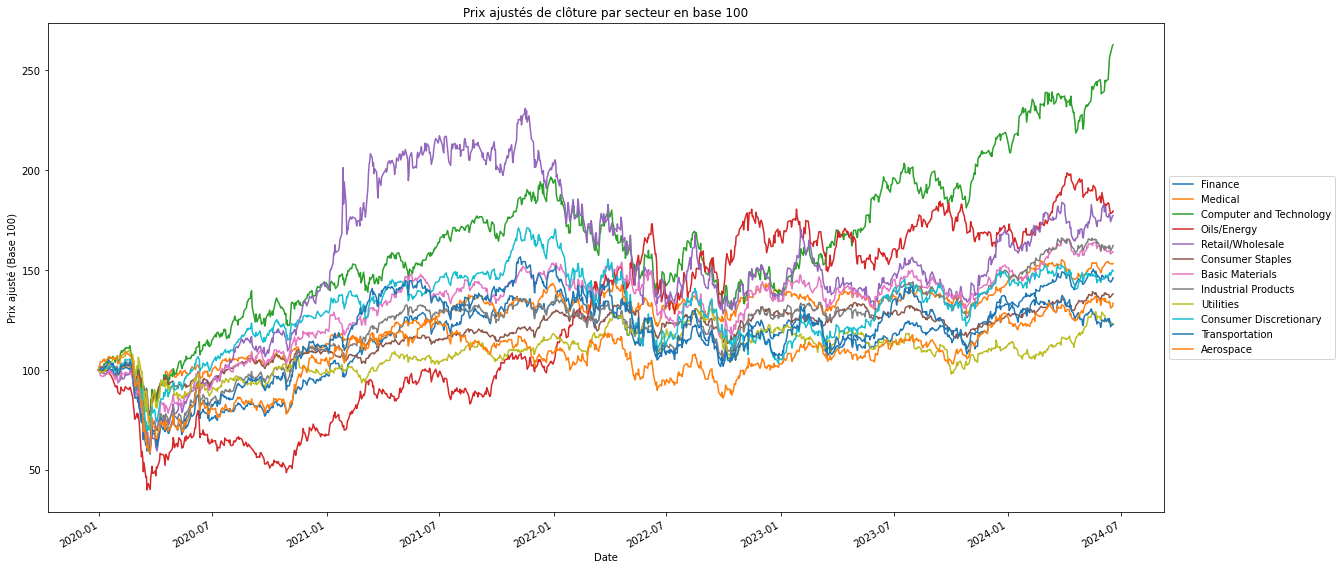

In [51]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Définir les tickers des ETF pour chaque secteur
sector_tickers = {
    "Finance": "XLF",
    "Medical": "XLV",
    "Computer and Technology": "XLK",
    "Oils/Energy": "XLE",
    "Retail/Wholesale": "XRT",
    "Consumer Staples": "XLP",
    "Basic Materials": "XLB",
    "Industrial Products": "XLI",
    "Utilities": "XLU",
    "Consumer Discretionary": "XLY",
    "Transportation": "XTN",
    "Aerospace": "XAR"
}

# Télécharger les données pour chaque ticker
data = {}
for sector, ticker in sector_tickers.items():
    try:
        # Téléchargement des données de prix ajustés de clôture
        data[sector] = yf.download(ticker, start="2020-01-01", end="2024-06-20")['Adj Close']
    except Exception as e:
        print(f"Échec du téléchargement pour {ticker}: {e}")

# Conversion en DataFrame
sector_data = pd.DataFrame(data)

# Mettre tous les titres en base 100
sector_data_base100 = (sector_data / sector_data.iloc[0]) * 100

# Vérification des données manquantes
sector_data_base100.info()

# Télécharger les données des taux d'intérêt de la FED
try:
    fed_rate = pd.read_excel('FEDFUNDS.xls')
    fed_rate['observation_date'] = pd.to_datetime(fed_rate['observation_date'])
    fed_rate.set_index('observation_date', inplace=True)
    fed_rate_selected = fed_rate.loc['2020-01-01':'2024-04-01']
except Exception as e:
    print(f"Échec du chargement des taux de la FED: {e}")

# Afficher les données de taux d'intérêt
print(fed_rate_selected.head())

# Graphiques
plt.figure(figsize=(30, 17))
ax = sector_data_base100.plot(title="Prix ajustés de clôture par secteur en base 100", figsize=(20, 10))
plt.ylabel("Prix ajusté (Base 100)")

# Positionner la légende à l'extérieur du graphique
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


Voici une analyse du graphique représentant les prix ajustés de clôture par secteur, normalisés en base 100, de janvier 2020 à mai 2024 :

1. **Tendances générales**:
   - La plupart des secteurs ont connu une chute notable en mars 2020, coïncidant probablement avec l'impact initial de la pandémie de COVID-19.
   - Après cette chute initiale, les secteurs ont montré une tendance générale à la hausse, bien que le rythme de la reprise et la stabilité varient d'un secteur à l'autre.

2. **Performance des secteurs spécifiques**:
   - **Computer and Technology (XLK)** : Ce secteur a montré une forte performance globale, atteignant des niveaux beaucoup plus élevés que la plupart des autres secteurs. Cela reflète probablement une forte demande pour les technologies numériques et le travail à distance pendant et après la pandémie.
   - **Consumer Discretionary (XLY)** et **Retail/Wholesale (XRT)** : Ces secteurs ont également bien performé, reflétant une demande soutenue pour les biens de consommation discrétionnaires et la vente au détail, notamment en ligne.
   - **Utilities (XLU)** et **Consumer Staples (XLP)** : Ces secteurs sont restés relativement stables, comme attendu, étant donné qu'ils incluent des biens et services de première nécessité. Leur croissance est modérée mais stable.
   - **Oils/Energy (XLE)** : Ce secteur montre une récupération plus lente et plus modeste. Les fluctuations des prix du pétrole et des politiques énergétiques ont probablement influencé cette performance.
   - **Aerospace (XAR)** : Ce secteur a connu une performance plus faible, probablement en raison de la réduction des voyages aériens pendant la pandémie et des incertitudes dans l'industrie de la défense.

3. **Variabilité et volatilité**:
   - Les secteurs **Medical (XLV)** et **Industrial Products (XLI)** montrent une certaine volatilité mais ont globalement suivi une tendance de croissance modérée.
   - **Finance (XLF)** : Ce secteur montre une reprise modérée après la chute initiale de 2020, influencée par les politiques monétaires et les conditions économiques globales.

4. **Comparaison globale**:
   - Les secteurs **Technology (XLK)** et **Consumer Discretionary (XLY)** sont les grands gagnants en termes de croissance depuis 2020.
   - Les secteurs **Oils/Energy (XLE)** et **Aerospace (XAR)** ont eu des performances relativement plus faibles.

5. **Impact des taux d'intérêt de la FED**:
   - Les mouvements des taux d'intérêt, bien que non visibles directement sur ce graphique, peuvent avoir eu un impact significatif, en particulier sur les secteurs financiers et les secteurs sensibles aux coûts d'emprunt comme les industriels et les matériaux de base.

Globalement, le graphique montre une reprise générale après l'impact initial de la pandémie, avec une forte performance dans les secteurs technologiques et de consommation discrétionnaire, tandis que les secteurs énergétiques et aérospatiaux ont montré des reprises plus lentes et plus modérées.

# Analyse quantitative

Pour utiliser les données de rendements mensuels des secteurs et évaluer l'impact des taux de la FED, nous allons d'abord calculer ces rendements et ensuite les aligner avec les taux d'intérêt pour mener des analyses de régression

### Explications:

1. **Rendements Mensuels**: Calcul des rendements mensuels des secteurs à partir des données journalières. Cela standardise la périodicité pour l'analyse avec les taux de la FED.
2. **Alignement des Données**: Concaténation des rendements des secteurs avec les taux de la FED mensualisés, puis élimination des lignes avec des données manquantes.
3. **Régression Linéaire**: Utilisation de la régression OLS pour déterminer l'impact des taux de la FED sur les rendements sectoriels.
4. **Tests de Granger**: Évaluation de la causalité potentielle des taux de la FED sur les rendements sectoriels.
5. **Modèles GARCH**: Analyse de la volatilité des rendements sectoriels pour examiner comment la volatilité réagit aux changements dans les taux de la FED.


In [52]:
# Calcul des variations des taux Fed Funds pour rendre les données stationnaires
fed_rate_diff = fed_rate_selected.pct_change().dropna()

# Application du test ADF
result = adfuller(fed_rate_diff)

# Impression des résultats
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interprétation du résultat basée sur la statistique ADF et la p-value
if result[1] < 0.05:
    print("Les variations des rendements de la Fed sont stationnaires.")
else:
    print("Les variations des rendements de la Fed ne sont pas stationnaires.")


ADF Statistic: -3.239067429708885
p-value: 0.01783178583497444
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
Les variations des rendements de la Fed sont stationnaires.


Les variations des rendements de la Fed sont stationnaires, ce qui signifie que leurs propriétés statistiques, telles que la moyenne et la variance, sont constantes dans le temps, nous pouvons donc utiliser ces données dans les modèles Garch et ARIMA par la suite

In [53]:
# Calcul de rendements mensuels pour les secteurs (pour les mettre au même niveau que la Fed)
monthly_returns = sector_data.resample('MS').ffill().pct_change()
# Alignement des données de rendements avec les taux
aligned_data = pd.concat([monthly_returns,fed_rate_diff], axis=1).dropna()

for sector in monthly_returns.columns:
    # Application du test ADF
    result = adfuller(aligned_data[sector])
    # Impression des résultats
    print('ADF Statistic '+sector+': ', result[0])
    print('p-value '+sector+': ', result[1])
    print('Critical Values '+sector+': ')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # Interprétation du résultat basée sur la statistique ADF et la p-value
    if result[1] < 0.05:
        print("Les rendements du secteur "+sector+ " sont stationnaires.")
    else:
        print("Les rendements du secteur "+sector+ " ne sont pas stationnaires.")

ADF Statistic Finance:  -5.234616721933501
p-value Finance:  7.468593004896537e-06
Critical Values Finance: 
	1%: -3.575
	5%: -2.924
	10%: -2.600
Les rendements du secteur Finance sont stationnaires.
ADF Statistic Medical:  -7.958426140900278
p-value Medical:  2.9935220165853803e-12
Critical Values Medical: 
	1%: -3.568
	5%: -2.921
	10%: -2.599
Les rendements du secteur Medical sont stationnaires.
ADF Statistic Computer and Technology:  -7.779715694235452
p-value Computer and Technology:  8.481160079362765e-12
Critical Values Computer and Technology: 
	1%: -3.568
	5%: -2.921
	10%: -2.599
Les rendements du secteur Computer and Technology sont stationnaires.
ADF Statistic Oils/Energy:  -7.364397692605895
p-value Oils/Energy:  9.31827316409064e-11
Critical Values Oils/Energy: 
	1%: -3.568
	5%: -2.921
	10%: -2.599
Les rendements du secteur Oils/Energy sont stationnaires.
ADF Statistic Retail/Wholesale:  -7.143116269986932
p-value Retail/Wholesale:  3.284855052849237e-10
Critical Values Ret

Globalement, les rendements de tous les ETFs sont stationnaires, à l'exception de ceux du secteur Utilities. Cependant, le secteur Utilities ne représente que 2,5% de la part de l'économie américaine, signifiant qu'il peut être négliger pour notre analyse.

In [60]:
# Régression linéaire
X = sm.add_constant(aligned_data['FEDFUNDS'])  # Ajouter une constante à l'ensemble de données
results = {}
for sector in monthly_returns.columns:#sector_tickers.values():
    model = sm.OLS(aligned_data[sector], X,mising='drop').fit()
    results[sector] = model.summary()

# Afficher les résumés de régression
for sector, result in results.items():
    print(f"Résultats de régression pour {sector}:\n{result}\n\n")

Résultats de régression pour Finance:
                            OLS Regression Results                            
Dep. Variable:                Finance   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.2020
Date:                Fri, 21 Jun 2024   Prob (F-statistic):              0.655
Time:                        13:11:57   Log-Likelihood:                 61.286
No. Observations:                  51   AIC:                            -118.6
Df Residuals:                      49   BIC:                            -114.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['mising']
  warnings.warn(msg, ValueWarning)
C:\Users\jeanb\anaconda3\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['m

A première vue, Dans l'ensemble, les taux des fonds fédéraux ne semblent pas avoir une relation statistiquement significative avec les rendements de la plupart des secteurs, à l'exception possible des secteurs de l'énergie et de l'aérospatiale. Cependant, même dans ces cas, la relation reste modeste. Les résultats suggèrent que les rendements des secteurs étudiés ne sont pas fortement influencés par les variations des taux des fonds fédéraux sur la période analysée.

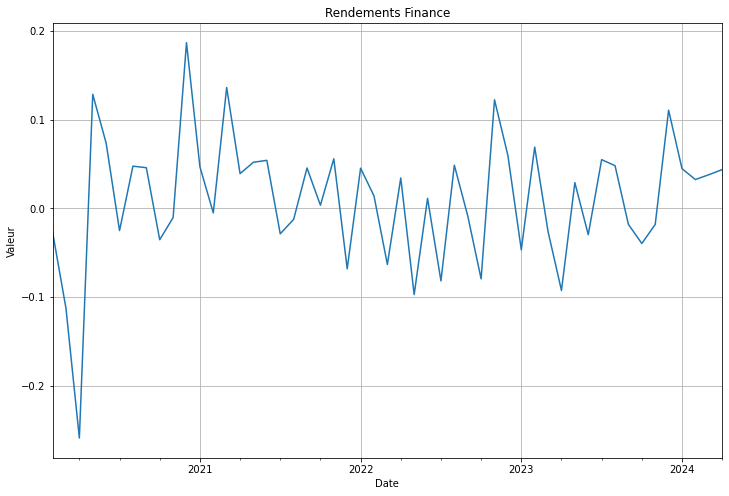

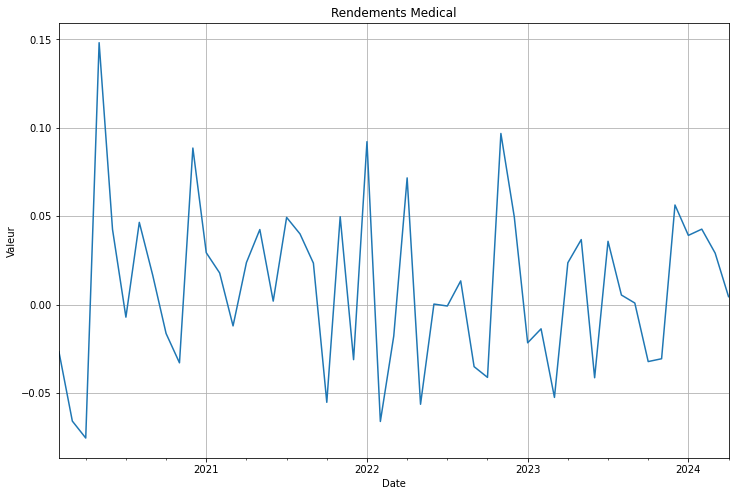

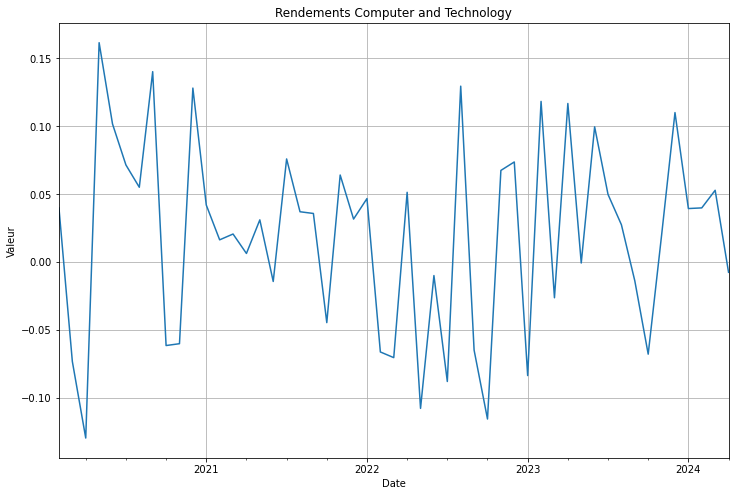

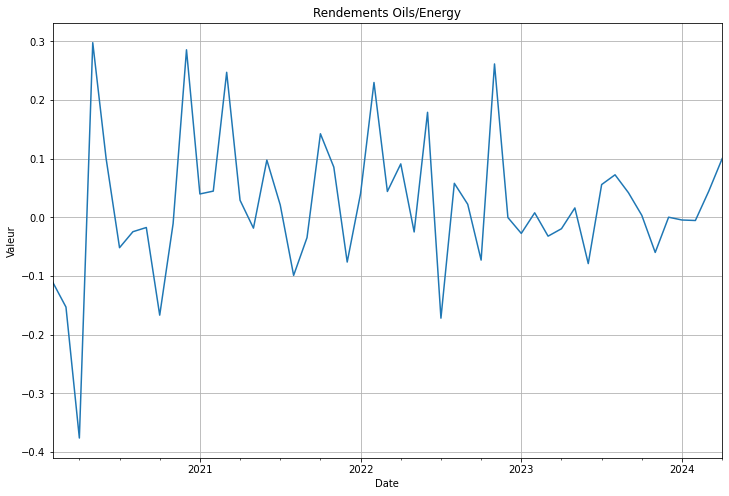

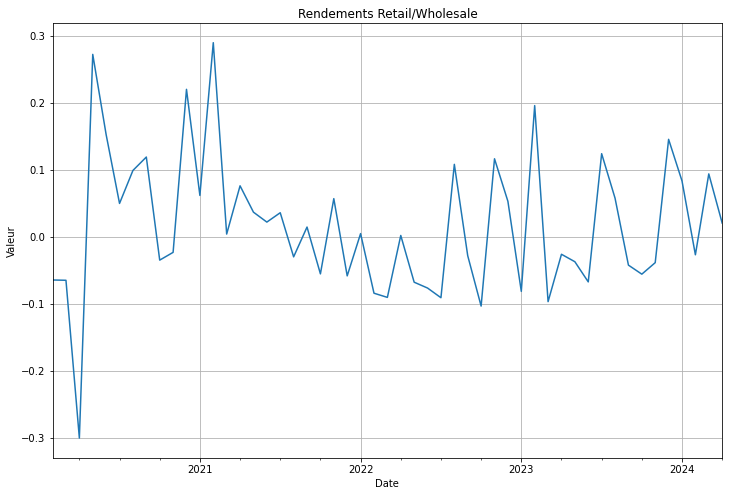

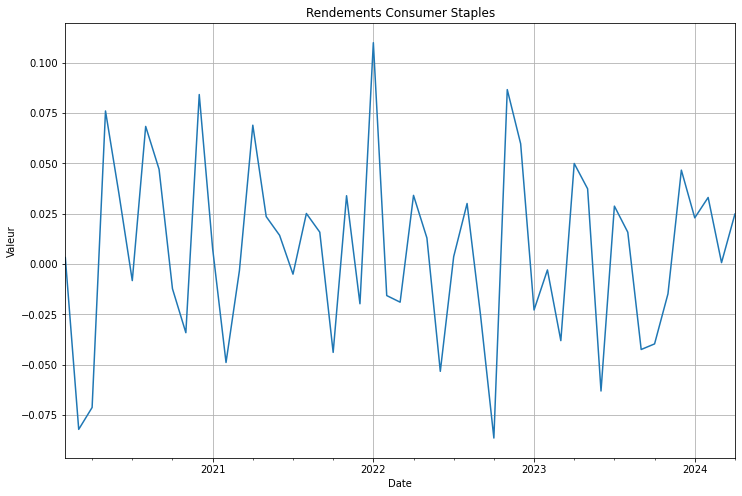

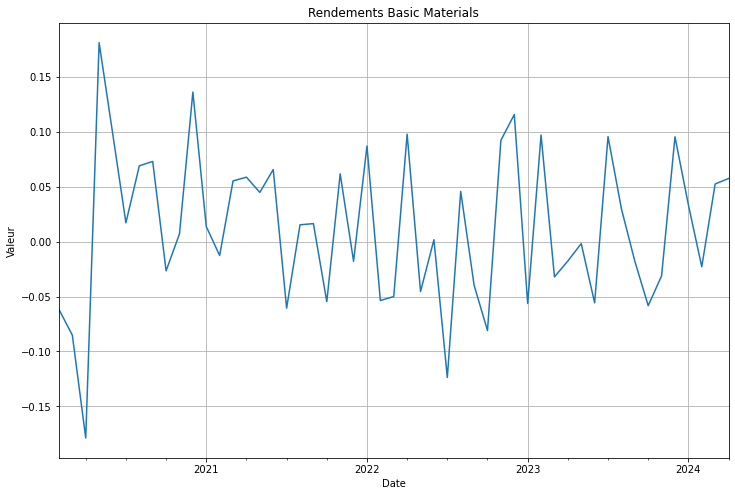

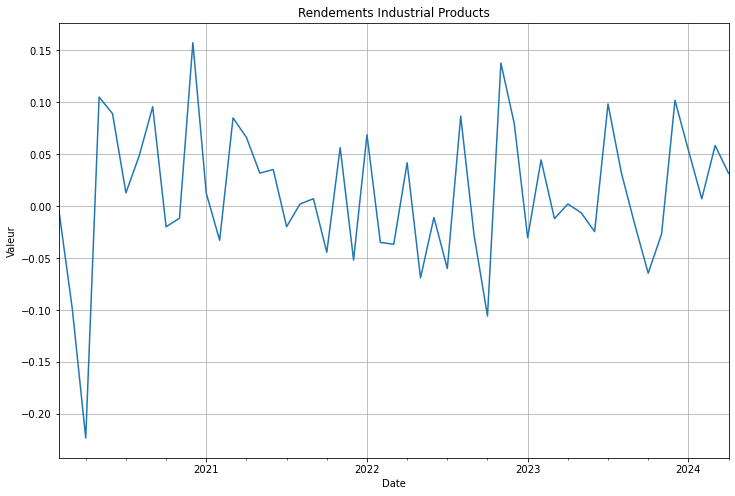

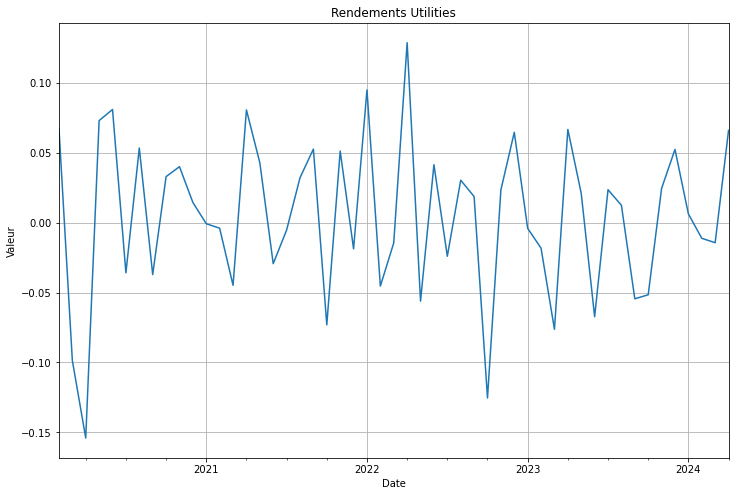

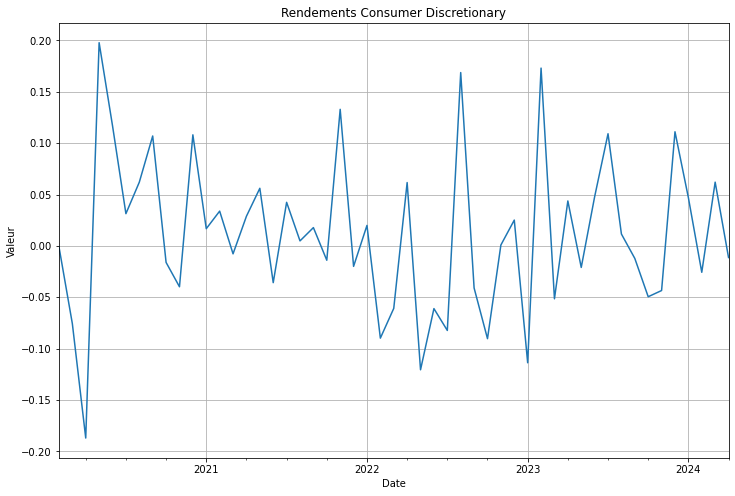

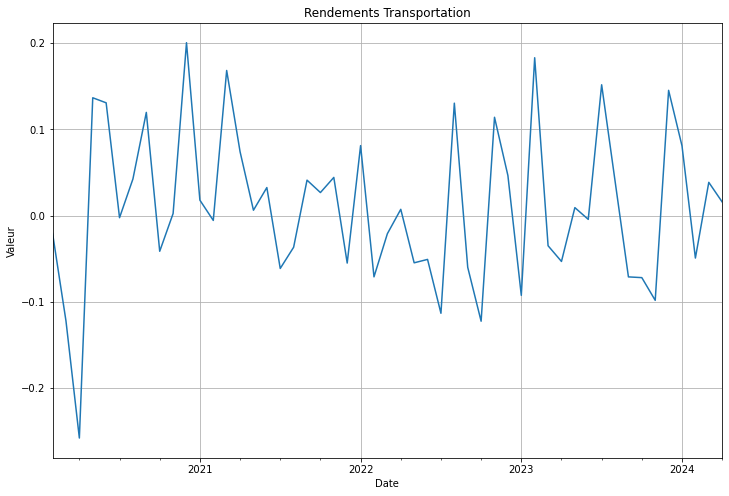

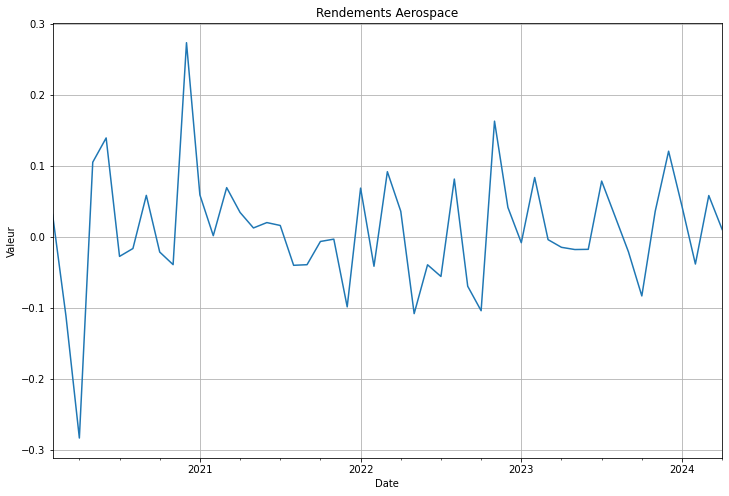

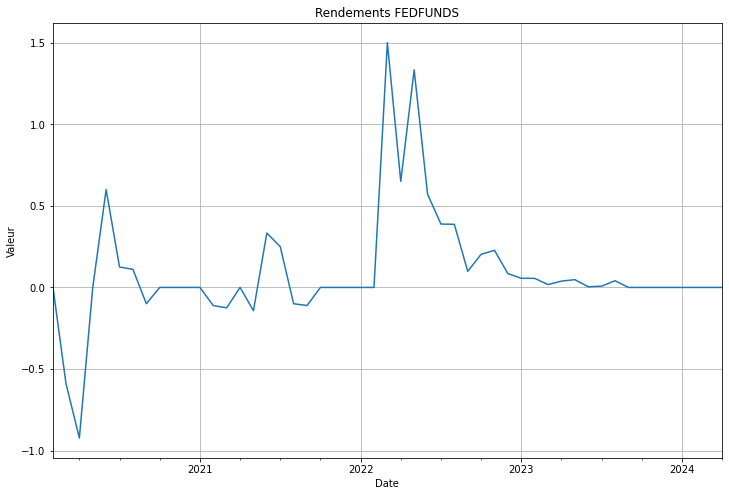

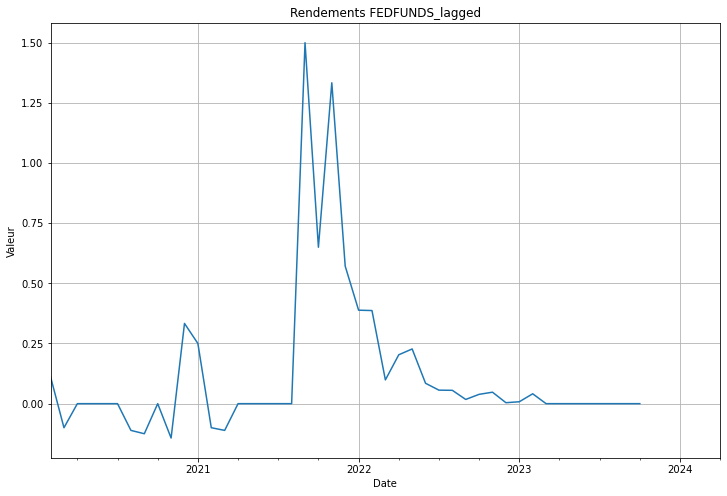

In [61]:
# Grahiques de chaque rendements
for sector in aligned_data.columns:
    aligned_data[sector].plot(figsize=(12, 8))
    plt.xlabel('Date')
    plt.ylabel('Valeur')
    plt.title('Rendements '+sector)
    plt.grid(True)
    
    # Positionner la légende à l'extérieur du graphique
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()

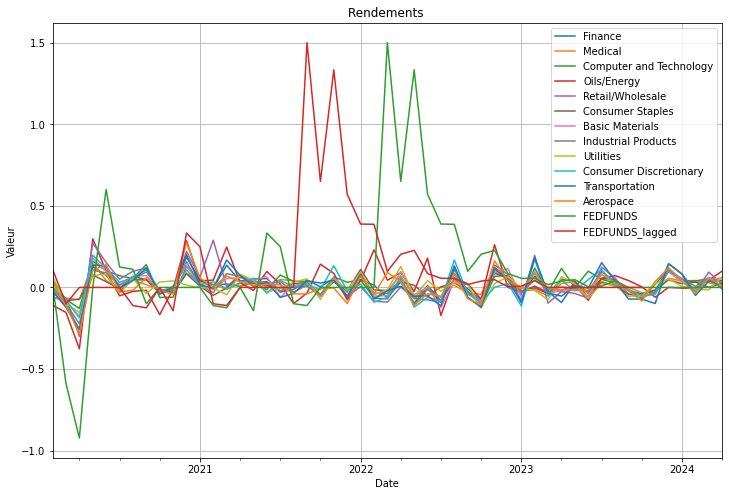

In [62]:
aligned_data.plot(figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Rendements ')
plt.grid(True)
plt.show()

Commentaire :le graphique indique que les variations des FEDFUNDS est beaucoup plus volatile que les autres secteurs. La plupart des autres secteurs montrent une stabilité relative avec des variations modérées autour de la ligne de base, ce qui peut être interprété comme une performance relativement stable en l'absence de chocs économiques majeurs. Les perturbations visibles dans les différents secteurs peuvent être attribuées à des événements économiques spécifiques influençant temporairement le marché.

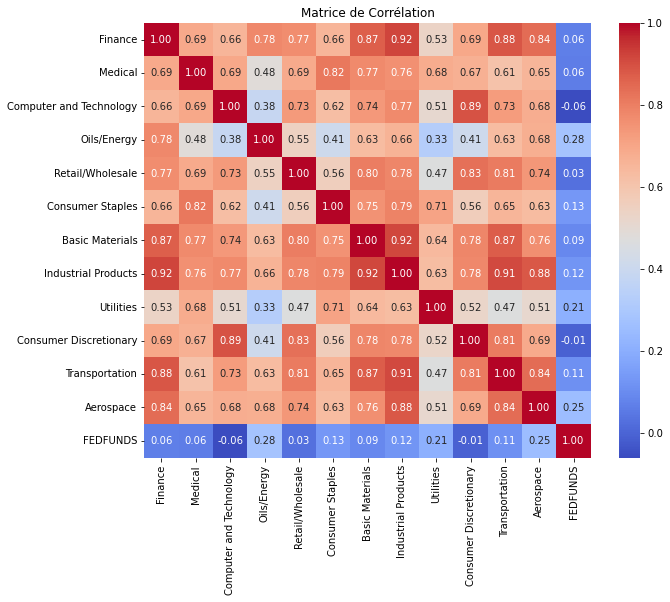

In [55]:
# Calcul de la matrice de corrélation
matriceCorrelation = np.corrcoef(aligned_data, rowvar=False)

# Ajustement de la taille de la figure
plt.figure(figsize=(10, 8))

# Création du heatmap avec seaborn
sns.heatmap(matriceCorrelation, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=aligned_data.columns, yticklabels=aligned_data.columns)

# Ajout d'un titre
plt.title('Matrice de Corrélation')

# Affichage de la figure
plt.show()

la matrice de corrélation révèle des relations étroites entre certains secteurs, en particulier ceux qui sont économiquement liés ou partagent des chaînes d'approvisionnement similaires. Les corrélations faibles ou négatives avec le taux des fonds fédéraux soulignent l'influence limitée de cette variable macroéconomique sur les rendements des secteurs individuels à l'instant t.
Il serait donc interessant de regarder l'impact des taux Fed en décallés sur trois mois ou six mois, pour observer étudier l'impact de la politique monétaire de la Fed à long terme

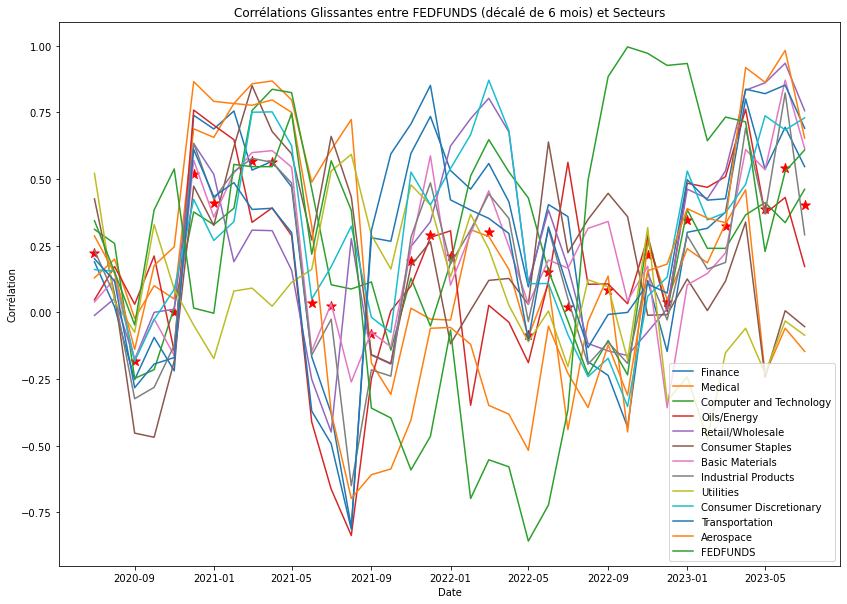

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que aligned_data est déjà chargé comme DataFrame avec des données mensuelles
# Décalage de la colonne FedFUNDS de 6 mois vers l'avant
aligned_data['FEDFUNDS_lagged'] = aligned_data['FEDFUNDS'].shift(-6)

# Supprimer les valeurs NA résultant du décalage
aligned_data_lagged = aligned_data.dropna()

# Fonction pour calculer les corrélations glissantes
def rolling_correlation(data, column1, column2, window_size):
    return data[column1].rolling(window=window_size).corr(data[column2])

# Taille de la fenêtre (6 mois)
window_size = 6

# Calcul des corrélations glissantes entre FEDFUNDS_lagged et chaque secteur
rolling_correlations = {}
for column in aligned_data_lagged.columns[:-1]:  # Exclure FEDFUNDS_lagged
    rolling_correlations[column] = rolling_correlation(aligned_data_lagged, 'FEDFUNDS_lagged', column, window_size)

# Création d'un DataFrame pour les corrélations glissantes
rolling_corr_df = pd.DataFrame(rolling_correlations, index=aligned_data_lagged.index)

# Liste des dates des réunions de la Fed (depuis 2020 jusqu'à aujourd'hui)
fed_meeting_dates = pd.to_datetime([
    '2020-01-29', '2020-03-18', '2020-04-29', '2020-06-10', 
    '2020-07-29', '2020-09-16', '2020-11-05', '2020-12-16',
    '2021-01-27', '2021-03-17', '2021-04-28', '2021-06-16', 
    '2021-07-28', '2021-09-22', '2021-11-03', '2021-12-15',
    '2022-01-26', '2022-03-16', '2022-05-04', '2022-06-15', 
    '2022-07-27', '2022-09-21', '2022-11-02', '2022-12-14',
    '2023-01-31', '2023-03-22', '2023-05-03', '2023-06-14', 
    '2023-07-26', '2023-09-20', '2023-11-01', '2023-12-13',
    '2024-01-31','2024-01-31','2024-03-20','2024-05-01','2024-06-12'
])

# Extraire les mois et années des dates de réunion
fed_meeting_months = fed_meeting_dates.to_period('M').to_timestamp()

# Tracer les corrélations glissantes
plt.figure(figsize=(14, 10))
for column in rolling_corr_df.columns:
    plt.plot(rolling_corr_df.index.to_numpy(), rolling_corr_df[column].to_numpy(), label=column)

# Ajouter des points rouges pour les dates des réunions de la Fed
for meeting_date in fed_meeting_months:
    if meeting_date in rolling_corr_df.index:
        plt.scatter([meeting_date], [rolling_corr_df.loc[meeting_date].mean()], color='red', s=100, marker='*')

plt.title('Corrélations Glissantes entre FEDFUNDS (décalé de 6 mois) et Secteurs')
plt.xlabel('Date')
plt.ylabel('Corrélation')
plt.legend(loc='best')
plt.show()



### Corrélations Générales
1. **Variabilité des Corrélations** :
   - Les corrélations varient considérablement au fil du temps pour tous les secteurs, indiquant des relations non stationnaires entre les taux des fonds fédéraux et les rendements des secteurs.
   - Les valeurs de corrélation fluctuent entre -0.75 et 1.0, montrant à la fois des corrélations positives et négatives significatives.

2. **Corrélations Positives et Négatives** :
   - À certains moments, certains secteurs montrent des corrélations positives élevées avec les taux des fonds fédéraux, par exemple autour de mi-2021 et début 2023.
   - En revanche, il y a des périodes où les corrélations sont négatives, notamment vers la fin de 2020 et début 2022.

### Réunions de la Fed
3. **Impact des Réunions de la Fed** :
   - Les étoiles rouges marquent les dates des réunions de la Fed.
   - Certaines réunions semblent coïncider avec des changements significatifs dans les corrélations, ce qui pourrait suggérer un impact retardé des décisions de la Fed sur certains secteurs.
   - Par exemple, après les réunions de la Fed en mi-2021, on observe des changements notables dans les tendances des corrélations.

### Secteurs Spécifiques
4. **Différences entre Secteurs** :
   - Certains secteurs montrent des variations plus importantes que d'autres. Par exemple, le secteur des "Basic Materials" et des "Transportation" montrent de fortes variations dans les corrélations.
   - Le secteur "Medical" montre des variations moins prononcées comparativement à d'autres secteurs.

5. **Corrélations Moyennes** :
   - Les points moyens des corrélations à chaque date de réunion montrent qu'en général, les corrélations ne s'écartent pas énormément autour de ces dates.

### Interprétation Globale
6. **Effet des Taux de la Fed** :
   - Le graphique suggère que les taux des fonds fédéraux ont un effet complexe et différé sur les rendements des différents secteurs.
   - Les variations montrent que les secteurs réagissent différemment aux changements des taux de la Fed, ce qui pourrait être influencé par divers facteurs macroéconomiques et spécifiques aux secteurs.

### Conclusion
En résumé, ce graphique met en évidence la nature dynamique et variable des relations entre les taux des fonds fédéraux et les rendements sectoriels. Les décisions de la Fed ont des impacts différés et non uniformes sur les différents secteurs, soulignant l'importance de considérer des fenêtres temporelles appropriées et de multiples facteurs économiques dans l'analyse des marchés financiers.

# 1. Tests de causalité de Granger
Ces tests permettent de déterminer si les taux d'intérêt peuvent prédire les rendements des secteurs.

Le test de Granger est une méthode statistique utilisée en économétrie pour déterminer si une série temporelle $ X $ peut être utilisée pour prédire une autre série temporelle $ Y $. Il est couramment utilisé pour examiner la causalité entre deux séries temporelles, en particulier dans le domaine de l'économie et de la finance.

Le test de Granger repose sur l'hypothèse selon laquelle si une série temporelle $ X $ est utile pour prédire une autre série temporelle $ Y $, alors les valeurs passées de $ X $ devraient fournir une information significative pour prédire les valeurs futures de $ Y $ au-delà de ce que les valeurs passées de $ Y $ peuvent fournir seules.

Le test de Granger est généralement effectué en deux étapes :

1. **Modélisation des données** : Les séries temporelles $ X $ et $ Y $ sont modélisées à l'aide d'un modèle de régression multivariée qui inclut les valeurs passées de $ X $ et de $ Y $ en tant que prédicteurs. Par exemple, si nous voulons tester si $ X $ Granger-causalise $ Y $, nous construirons un modèle de régression de la forme :

   $$
   Y_t = \alpha + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{j=1}^{q} \gamma_j X_{t-j} + \epsilon_t
   $$

   où $ \alpha $ est l'ordonnée à l'origine, $ \beta_i $ et $ \gamma_j $ sont les coefficients des valeurs passées de $ Y $ et de $ X $ respectivement, $ p $ et $ q $ sont les ordres du modèle pour les séries $ Y $ et $ X $, et $ \epsilon_t $ est le terme d'erreur.

2. **Test statistique** : Une fois que le modèle est estimé, un test statistique est utilisé pour évaluer si les coefficients associés aux valeurs passées de $ X $ sont statistiquement significatifs. Si les coefficients associés à $ X $ sont statistiquement significatifs, cela suggère que $ X $ Granger-cause $ Y $, c'est-à-dire que l'ajout des valeurs passées de $ X $ améliore significativement la capacité du modèle à prédire $ Y $.

Le test de Granger est souvent utilisé pour explorer les relations de causalité dans les séries temporelles économiques, telles que la relation entre l'inflation et la croissance économique, les taux d'intérêt et l'investissement, etc. Cependant, il est important de noter que la présence d'une corrélation entre deux séries temporelles ne garantit pas nécessairement une relation de causalité. D'autres facteurs et tests doivent également être pris en compte pour établir une relation causale robuste.

In [9]:
# Tests de Granger pour chaque secteur par rapport aux taux de la FED
granger_results = {}
print(sector_data.columns)
for sector in sector_data.columns:
    data_for_test = aligned_data[[sector, 'FEDFUNDS']].dropna()
    granger_result = grangercausalitytests(data_for_test, maxlag=4, verbose=False)
    granger_results[sector] = granger_result
    # Afficher un résumé simple pour chaque secteur
    print(f"Granger Causality results for {sector}:")
    for lag, result in granger_result.items():
        p_value = result[0]['ssr_chi2test'][1]
        print(f"  Lag {lag} p-value: {p_value:.4f}")

Index(['Finance', 'Medical', 'Computer and Technology', 'Oils/Energy',
       'Retail/Wholesale', 'Consumer Staples', 'Basic Materials',
       'Industrial Products', 'Utilities', 'Consumer Discretionary',
       'Transportation', 'Aerospace'],
      dtype='object')
Granger Causality results for Finance:
  Lag 1 p-value: 0.6718
  Lag 2 p-value: 0.0029
  Lag 3 p-value: 0.0052
  Lag 4 p-value: 0.0045
Granger Causality results for Medical:
  Lag 1 p-value: 0.8258
  Lag 2 p-value: 0.0372
  Lag 3 p-value: 0.1125
  Lag 4 p-value: 0.1176
Granger Causality results for Computer and Technology:
  Lag 1 p-value: 0.6346
  Lag 2 p-value: 0.0022
  Lag 3 p-value: 0.0202
  Lag 4 p-value: 0.0161
Granger Causality results for Oils/Energy:
  Lag 1 p-value: 0.7054
  Lag 2 p-value: 0.0242
  Lag 3 p-value: 0.0041
  Lag 4 p-value: 0.0010
Granger Causality results for Retail/Wholesale:
  Lag 1 p-value: 0.3247
  Lag 2 p-value: 0.0080
  Lag 3 p-value: 0.2576
  Lag 4 p-value: 0.7011
Granger Causality results for

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarn



| Secteur                    | Lags de Causalité Significative (mois) |
|----------------------------|---------------------------------------|
| Finance                    | 2, 3, 4                               |
| Medical                    | 2                                     |
| Computer and Technology    | 2, 3, 4                               |
| Oils/Energy                | 2, 3, 4                               |
| Retail/Wholesale           | 2                                     |
| Consumer Staples           | Aucun                                 |
| Basic Materials            | 2, 3, 4                               |
| Industrial Products        | 2, 4                                  |
| Utilities                  | 2                                     |
| Consumer Discretionary     | 2, 3                                  |
| Transportation             | 2, 4                                  |
| Aerospace                  | 2, 3                                  |

### Conclusion

- Les secteurs **Finance**, **Computer and Technology**, **Oils/Energy**, **Basic Materials** montrent des relations significatives avec les taux des fonds fédéraux à plusieurs retards (2, 3, et 4 mois).
- Les secteurs **Medical**, **Retail/Wholesale**, **Utilities** montrent une relation significative avec un retard de 2 mois.
- Les secteurs **Industrial Products**, **Consumer Discretionary**, **Transportation**, **Aerospace** montrent des relations significatives à différents retards, principalement autour de 2 et 4 mois.
- Le secteur **Consumer Staples** ne montre aucune relation significative avec les taux des fonds fédéraux pou
estion de portefeuille.

Les résultats des tests de Granger montrent que les taux des fonds fédéraux Granger-causent les rendements de plusieurs secteurs à différents retards, en particulier pour les secteurs financiers, technologiques, de l'énergie, des matériaux de base, des produits industriels, des services publics, des produits de consommation discrétionnaire, des transports et de l'aérospatiale. Les secteurs des produits de consommation courante ne montrent pas de relation significative.

Ces résultats suggèrent que les variations des taux des fonds fédéraux peuvent être utilisées pour prédire les rendements des secteur.gestion de portefeuille.

# 2. Analyse de la volatilité avec des modèles GARCH
L'analyse de la volatilité avec des modèles GARCH peut montrer comment la volatilité du secteur réagit aux changements de politique monétaire.


Le modèle GARCH( p , q ) pour une série temporelle $ y_t $ est défini comme suit :

$$ y_t = \mu_t + \epsilon_t $$
$$ \epsilon_t = \sigma_t \cdot z_t $$

Où :
- $ \mu_t $ est la moyenne conditionnelle de la série temporelle à un moment $ t $.
- $ \epsilon_t $ est le résidu à un moment $ t $.
- $ \sigma_t $ est la racine carrée de la variance conditionnelle de $ \epsilon_t $, c'est-à-dire la volatilité conditionnelle à un moment $ t $.
- $ z_t $ est une variable aléatoire standardisée qui suit une distribution normale centrée réduite.

La volatilité conditionnelle $ \sigma_t^2 $ est modélisée comme une combinaison linéaire de ses valeurs passées et des carrés de ses résidus passés, selon la forme générale :

$$ \sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \cdot \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \cdot \sigma_{t-j}^2 $$

Où :
- $ \omega $ est la constante.
- $ \alpha_i $ sont les coefficients des résidus au carré.
- $ \beta_j $ sont les coefficients des valeurs passées de la volatilité.

En résumé, le modèle GARCH est un modèle où la variance conditionnelle est modélisée comme une fonction linéaire de ses propres valeurs passées et des carrés de ses résidus passés. Les paramètres du modèle $ \omega $, $ \alpha $ et $ \beta $ sont estimés à l'aide de méthodes d'estimation statistique telles que la méthode des moindres carrés ordinaires (MCO) ou la méthode du maximum de vraisemblance. Une fois que les paramètres sont estimés, le modèle peut être utilisé pour prédire la volatilité future de la série temporelle.

In [10]:
# Modèles GARCH pour chaque secteur
garch_results = {}
for sector in sector_data.columns:
    returns = aligned_data[sector].dropna()
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fitted = model.fit(disp='off')
    garch_results[sector] = garch_fitted
    print(f"GARCH model results for {sector}:\n{garch_fitted.summary()}\n")

GARCH model results for Finance:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Finance   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                63.9726
Distribution:                  Normal   AIC:                          -119.945
Method:            Maximum Likelihood   BIC:                          -112.297
                                        No. Observations:                   50
Date:                Thu, Jun 20 2024   Df Residuals:                       49
Time:                        23:17:10   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0121 

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002181. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

GARCH model results for Transportation:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Transportation   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                49.8907
Distribution:                  Normal   AIC:                          -91.7814
Method:            Maximum Likelihood   BIC:                          -84.1334
                                        No. Observations:                   50
Date:                Thu, Jun 20 2024   Df Residuals:                       49
Time:                        23:17:11   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             

### Impact des Résultats des Modèles GARCH sur l'Économie Américaine

Les modèles GARCH offrent une perspective approfondie sur la dynamique de la volatilité des rendements sectoriels. Voici une analyse axée sur l'impact potentiel de ces résultats sur l'économie américaine.

### Secteur Finance
- **Constante (mu)**: Non significative.
- **Volatilité**: Forte persistance de la volatilité.
- **Impact**: La volatilité persistante dans le secteur financier peut affecter la stabilité des marchés financiers. Une volatilité prolongée peut influencer les coûts de financement, l'accès au crédit, et la confiance des investisseurs, ce qui peut ralentir l'activité économique globale.

### Secteur Medical
- **Constante (mu)**: Significative et positive.
- **Volatilité**: Réactivité élevée aux chocs.
- **Impact**: La performance positive et réactive du secteur médical peut attirer des investissements, stimulant ainsi l'innovation et la croissance dans le secteur de la santé. Cependant, la réactivité élevée aux chocs peut aussi indiquer une sensibilité aux événements macroéconomiques ou aux politiques de santé, influençant les dépenses de santé publique et privée.

### Secteur Computer and Technology
- **Constante (mu)**: Significative et positive.
- **Volatilité**: Réactivité aux chocs et persistance.
- **Impact**: Le secteur des technologies de l'information est un moteur crucial de l'innovation et de la productivité économique. Une performance positive soutenue peut renforcer la compétitivité globale de l'économie américaine. Cependant, la réactivité aux chocs nécessite une surveillance continue des politiques technologiques et de la cybersécurité pour éviter des perturbations majeures.

### Secteur Oils/Energy
- **Constante (mu)**: Non significative.
- **Volatilité**: Très forte persistance de la volatilité.
- **Impact**: La volatilité persistante dans le secteur de l'énergie peut affecter les coûts de production et les prix de l'énergie, influençant directement les coûts des entreprises et des ménages. Une volatilité prolongée peut également compliquer les investissements à long terme dans les infrastructures énergétiques, impactant la sécurité énergétique nationale.

### Secteur Retail/Wholesale
- **Constante (mu)**: Non significative.
- **Volatilité**: Forte persistance de la volatilité.
- **Impact**: La volatilité persistante dans le secteur de la vente au détail et en gros peut refléter des changements dans la demande des consommateurs et des perturbations de la chaîne d'approvisionnement. Cela peut affecter la consommation intérieure, un pilier essentiel de l'économie américaine, et influencer les politiques monétaires et fiscales.

### Secteur Consumer Staples
- **Constante (mu)**: Non significative.
- **Volatilité**: Très forte persistance de la volatilité.
- **Impact**: Les produits de consommation courante sont essentiels pour la stabilité économique. La persistance de la volatilité peut indiquer une sensibilité aux changements de prix et aux revenus des ménages, influençant la demande et la stabilité économique globale.

### Secteur Basic Materials
- **Constante (mu)**: Non significative.
- **Volatilité**: Réactivité modérée et persistance.
- **Impact**: Le secteur des matériaux de base est crucial pour les industries manufacturières. Une volatilité modérée peut affecter les coûts de production et les prix des biens intermédiaires, influençant la compétitivité des exportations américaines et la balance commerciale.

### Secteur Industrial Products
- **Constante (mu)**: Significative et positive.
- **Volatilité**: Réactivité aux chocs.
- **Impact**: La performance positive dans le secteur des produits industriels peut stimuler la production manufacturière et les exportations. Cependant, une réactivité élevée aux chocs peut indiquer une vulnérabilité aux fluctuations économiques mondiales, nécessitant des politiques industrielles robustes.

### Secteur Utilities
- **Constante (mu)**: Non significative.
- **Volatilité**: Forte persistance de la volatilité.
- **Impact**: Le secteur des services publics est essentiel pour les infrastructures critiques. Une volatilité persistante peut indiquer des risques pour la stabilité des services de base, influençant les coûts pour les entreprises et les ménages, et nécessitant des régulations stables et prévisibles.

### Secteur Consumer Discretionary
- **Constante (mu)**: Non significative.
- **Volatilité**: Persistance et réactivité aux chocs.
- **Impact**: La consommation discrétionnaire est un indicateur clé de la confiance des consommateurs. Une volatilité dans ce secteur peut refléter des changements dans la confiance économique et les dépenses discrétionnaires, influençant la croissance économique.

### Secteur Transportation
- **Constante (mu)**: Non significative.
- **Volatilité**: Forte persistance de la volatilité.
- **Impact**: Le secteur des transports est vital pour le commerce et la logistique. Une volatilité persistante peut affecter les coûts de transport, les délais de livraison, et la compétitivité des entreprises américaines, nécessitant des investissements continus dans les infrastructures de transport.

### Secteur Aerospace
- **Constante (mu)**: Non significative.
- **Volatilité**: Très forte persistance de la volatilité.
- **Impact**: Le secteur de l'aérospatiale est crucial pour la défense nationale et les exportations technologiques. Une volatilité persistante peut indiquer des risques pour les investissements à long terme et la compétitivité mondiale, influençant les politiques de défense et les partenariats internationaux.

### Implications Générales pour l'Économie Américaine
1. **Stabilité Financière**: La persistance de la volatilité dans plusieurs secteurs clés peut affecter la stabilité financière globale, nécessitant des politiques monétaires et fiscales adaptées pour gérer les risques macroéconomiques.
2. **Innovation et Productivité**: Les secteurs avec des performances positives, tels que les technologies de l'information et les produits industriels, peuvent renforcer l'innovation et la productivité, soutenant la croissance économique à long terme.
3. **Gestion des Risques**: La réactivité aux chocs de volatilité dans certains secteurs nécessite des stratégies de gestion des risques robustes pour protéger les investissements et assurer la résilience économique.
4. **Consommation et Demande Intérieure**: Les fluctuations dans les secteurs de la consommation peuvent influencer la demande intérieure, un facteur clé de la croissance économique. Les politiques visant à stabiliser les revenus des ménages et à soutenir la consommation sont essentielles.
5. **Infrastructure et Investissements**: La volatilité dans les secteurs de l'énergie, des transports et des services publics souligne l'importance des investissements continus dans les infrastructures critiques pour soutenir la croissance économique et assurer la sécurité nationale.

En conclusion, les résultats des modèles GARCH révèlent des dynamiques complexes de volatilité dans différents secteurs de l'économie américaine. Comprendre et gérer ces dynamiques est crucial pour maintenir la stabilité économique, promouvoir la croissance, et assurer la résilience face aux chocs économiques. Les politiques économiques doivent être adaptées pour soutenir les secteurs performants, gérer les risques de volatilité, et renforcer les infrastructures critiques.'élaboration de stratégies pour maximiser les rendements ajustés au risque.

# 3. Modèles ARIMA pour la prédiction
Utilisation du modèle ARIMA pour prédire l'impact futur des changements des taux sur les indices sectoriels.

Le modèle ARIMA, qui signifie "AutoRegressive Integrated Moving Average", est un modèle statistique utilisé pour modéliser et prévoir les séries temporelles. Il combine les composantes d'autorégression (AR), de moyenne mobile (MA) et d'intégration (I) pour capturer les tendances, les structures de dépendance et les modèles saisonniers des données temporelles.

Voici une explication détaillée de chaque composante :

1. **Composante AR (AutoRegressive)** :
   - L'autorégression fait référence à la régression d'une variable sur ses valeurs passées. Dans un modèle ARIMA, la composante AR représente la relation linéaire entre la variable dépendante et ses propres valeurs retardées. 
   - La notation AR(p) indique qu'il y a p termes AR dans le modèle, ce qui signifie que la valeur actuelle de la série temporelle dépend des p valeurs précédentes.

2. **Composante MA (Moving Average)** :
   - La moyenne mobile est une moyenne des erreurs de prédiction sur une période de temps donnée. Dans un modèle ARIMA, la composante MA représente la dépendance linéaire entre la variable dépendante et les termes d'erreur de ses valeurs retardées.
   - La notation MA(q) indique qu'il y a q termes MA dans le modèle, ce qui signifie que la valeur actuelle de la série temporelle dépend des q erreurs de prédiction précédentes.

3. **Composante I (Integrated)** :
   - L'intégration est utilisée pour rendre la série temporelle stationnaire en différenciant la série à un certain ordre. Cela peut être nécessaire lorsque la série temporelle présente une tendance ou une saisonnalité non stationnaire.
   - La notation I(d) indique qu'il y a eu d différences pour rendre la série temporelle stationnaire.

En combinant ces trois composantes, un modèle ARIMA peut être écrit comme ARIMA(p, d, q), où :
- p est l'ordre de la composante AR.
- d est l'ordre de différenciation.
- q est l'ordre de la composante MA.

Le processus de construction d'un modèle ARIMA implique généralement les étapes suivantes :
1. Identification : Identifier les ordres p, d et q en examinant les graphiques de la série temporelle et les fonctions d'autocorrélation partielle et d'autocorrélation.
2. Estimation : Estimer les paramètres du modèle à l'aide de méthodes telles que la méthode des moindres carrés ordinaires (MCO) ou la méthode du maximum de vraisemblance.
3. Diagnostic : Tester la qualité du modèle en vérifiant si les résidus sont stationnaires et si le modèle est capable de capturer les structures temporelles de la série.
4. Prévision : Utiliser le modèle pour faire des prévisions sur les valeurs futures de la série temporelle.

En résumé, le modèle ARIMA est un outil puissant pour modéliser et prévoir les séries temporelles en capturant les tendances, les structures de dépendance et les modèles saisonniers des données.

1. **Composante AR (AutoRegressive)** :
   - La composante AR d'ordre p est donnée par l'équation :
     $ X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_p X_{t-p} + \varepsilon_t $
     où $ X_t $ est la série temporelle à l'instant t,
     $ c $ est la constante,
     $ \phi_1, \phi_2, ..., \phi_p $ sont les coefficients AR,
     $ \varepsilon_t $ est le terme d'erreur blanc à l'instant t.

2. **Composante MA (Moving Average)** :
   - La composante MA d'ordre q est donnée par l'équation :
     $$ X_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + ... + \theta_q \varepsilon_{t-q} $$
     où $ \theta_1, \theta_2, ..., \theta_q $ sont les coefficients MA.

3. **Composante I (Integrated)** :
   - La composante intégrée est utilisée pour rendre la série temporelle stationnaire en différenciant la série. Si on différencie la série une fois (d=1), on obtient :
     $$ Y_t = X_t - X_{t-1} $$
   - Si on différencie la série d fois (d=d), on obtient :
     $$ Y_t = (1 - B)^d X_t $$
     où $ B $ est l'opérateur de retard, tel que $ B^d X_t = X_{t-d} $.

Ainsi, un modèle ARIMA(p, d, q) peut être écrit mathématiquement comme suit :
$$ Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + ... + \theta_q \varepsilon_{t-q} + \varepsilon_t $$

Après estimation des coefficients, ce modèle peut être utilisé pour faire des prévisions sur les valeurs futures de la série temporelle $ X_t $.
rie temporelle \( X_t \).

Autocorrélogrammes pour Finance
ADF Statistic: -4.958097
p-value: 0.000027
La série est stationnaire


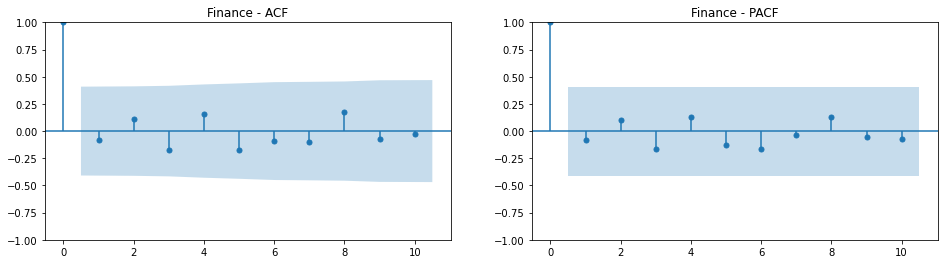

Autocorrélogrammes pour Medical
ADF Statistic: -4.102265
p-value: 0.000960
La série est stationnaire


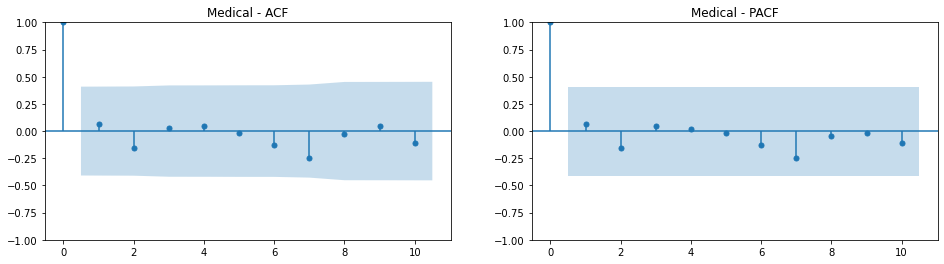

Autocorrélogrammes pour Computer and Technology
ADF Statistic: -3.194868
p-value: 0.020284
La série est stationnaire


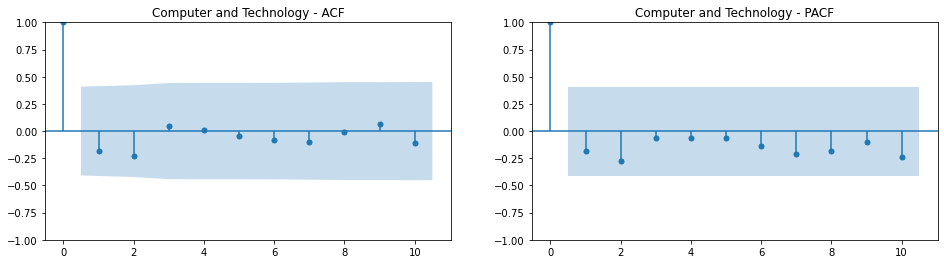

Autocorrélogrammes pour Oils/Energy
ADF Statistic: -4.677655
p-value: 0.000093
La série est stationnaire


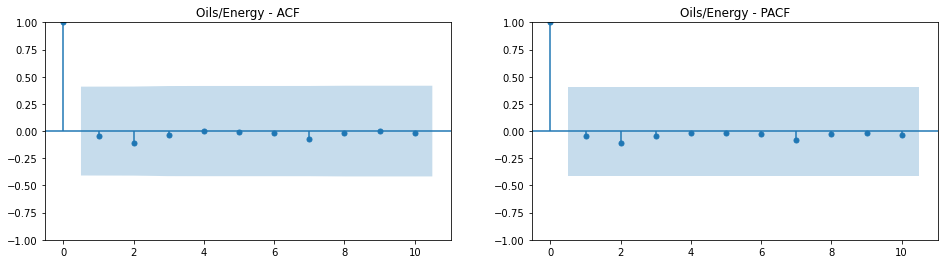

Autocorrélogrammes pour Retail/Wholesale
ADF Statistic: -4.581515
p-value: 0.000140
La série est stationnaire


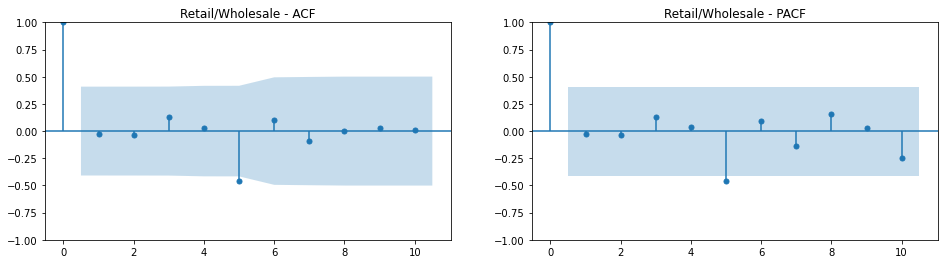

Autocorrélogrammes pour Consumer Staples
ADF Statistic: -7.692491
p-value: 0.000000
La série est stationnaire


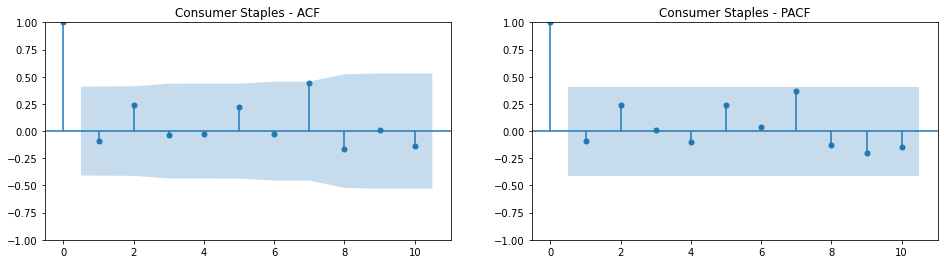

Autocorrélogrammes pour Basic Materials
ADF Statistic: -4.675423
p-value: 0.000094
La série est stationnaire


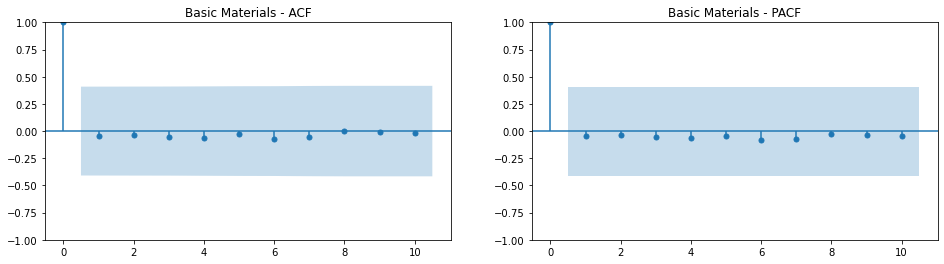

Autocorrélogrammes pour Industrial Products
ADF Statistic: -8.879378
p-value: 0.000000
La série est stationnaire


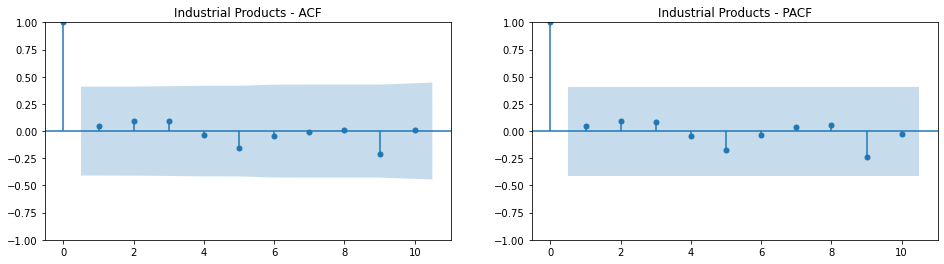

Autocorrélogrammes pour Utilities
ADF Statistic: -3.874433
p-value: 0.002231
La série est stationnaire


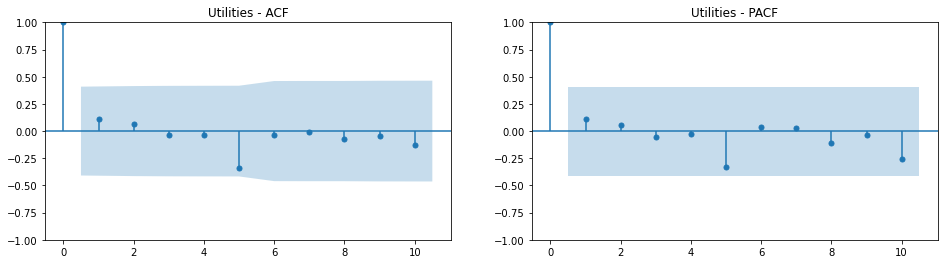

Autocorrélogrammes pour Consumer Discretionary
ADF Statistic: -14.230617
p-value: 0.000000
La série est stationnaire


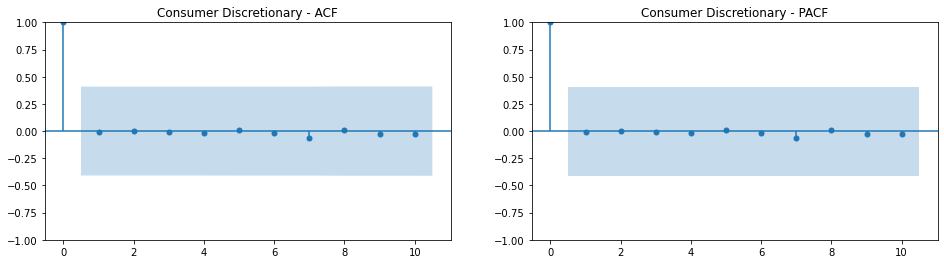

Autocorrélogrammes pour Transportation
ADF Statistic: -5.979473
p-value: 0.000000
La série est stationnaire


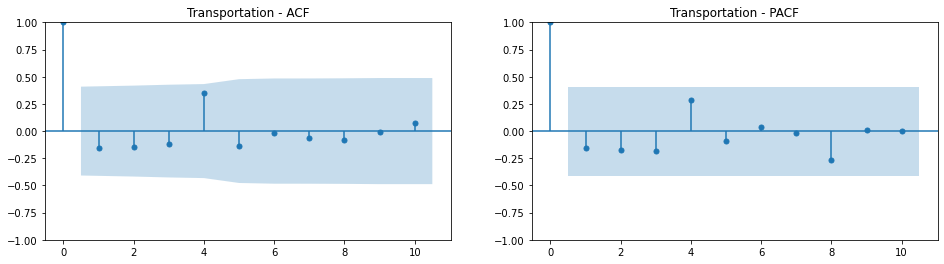

Autocorrélogrammes pour Aerospace
ADF Statistic: -4.545641
p-value: 0.000162
La série est stationnaire


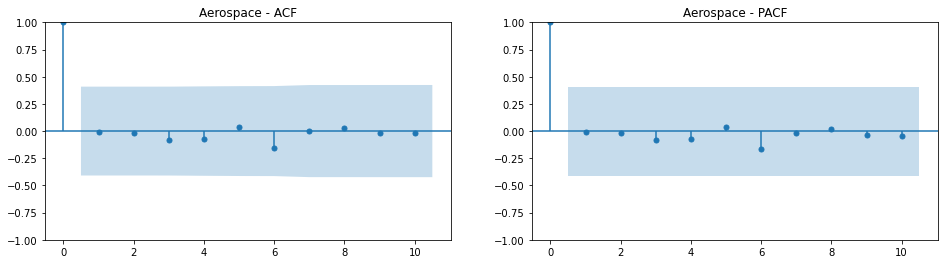

Autocorrélogrammes pour FEDFUNDS


MissingDataError: exog contains inf or nans

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Vérifier la stationnarité des séries
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

# Tracer les ACF et PACF
def plot_acf_pacf(data, lags, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(data, lags=lags, ax=axes[0])
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[0].set_title(f'{title} - ACF')
    axes[1].set_title(f'{title} - PACF')
    plt.show()

# Calculer les retours
returns_data = aligned_data.pct_change().dropna()

# Boucle pour chaque secteur
for sector in returns_data.columns:
    print(f"Autocorrélogrammes pour {sector}")
    check_stationarity(returns_data[sector])
    # Déterminer le nombre de lags en fonction de la taille de l'échantillon
    lags = min(10, len(returns_data[sector]) // 2 - 1)
    plot_acf_pacf(returns_data[sector], lags=lags, title=sector)

# Après avoir examiné les ACF et PACF, ajuster les modèles ARIMA
for sector in returns_data.columns:
    # Ajuster le modèle ARIMA
    p, d, q = 1, 1, 0  # Choix des ordres ARIMA basés sur ACF/PACF et critères
    model = ARIMA(returns_data[sector], order=(p, d, q))
    fitted_model = model.fit()
    
    # Prévisions futures
    forecast = fitted_model.forecast(steps=12)  # Prévoir les 12 prochains mois
    print("Prévisions des rendements du secteur " + sector)
    print(forecast)
    
    # Afficher les résumés des modèles
    print(fitted_model.summary())
    print("\n")


In [11]:
for sector in sector_data.columns:
    # Modélisation ARIMA sur les retours du secteur
    model = ARIMA(aligned_data[sector], order=(1, 1, 1))  # Modèle ARIMA(1,1,1)
    fitted_model = model.fit()
    
    # Prévisions futures
    forecast = fitted_model.forecast(steps=12)  # Prévoir les 12 prochains mois
    print("Prévisions des rendements du secteur "+sector)
    print(forecast)


Prévisions des rendements du secteur Finance
2024-05-01    0.010738
2024-06-01    0.011370
2024-07-01    0.011358
2024-08-01    0.011358
2024-09-01    0.011358
2024-10-01    0.011358
2024-11-01    0.011358
2024-12-01    0.011358
2025-01-01    0.011358
2025-02-01    0.011358
2025-03-01    0.011358
2025-04-01    0.011358
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Medical
2024-05-01    0.011340
2024-06-01    0.010315
2024-07-01    0.010468
2024-08-01    0.010445
2024-09-01    0.010449
2024-10-01    0.010448
2024-11-01    0.010448
2024-12-01    0.010448
2025-01-01    0.010448
2025-02-01    0.010448
2025-03-01    0.010448
2025-04-01    0.010448
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Computer and Technology
2024-05-01    0.021905
2024-06-01    0.019193
2024-07-01    0.019444
2024-08-01    0.019421
2024-09-01    0.019423
2024-10-01    0.019422
2024-11-01    0.019423
2024-12-01    0.019423
2025-01-01    0.019

/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/jihanesabri/Documents/M2/Macro/pythonProject/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prévisions des rendements du secteur Transportation
2024-05-01    0.010617
2024-06-01    0.010797
2024-07-01    0.010791
2024-08-01    0.010791
2024-09-01    0.010791
2024-10-01    0.010791
2024-11-01    0.010791
2024-12-01    0.010791
2025-01-01    0.010791
2025-02-01    0.010791
2025-03-01    0.010791
2025-04-01    0.010791
Freq: MS, Name: predicted_mean, dtype: float64
Prévisions des rendements du secteur Aerospace
2024-05-01    0.008439
2024-06-01    0.008389
2024-07-01    0.008388
2024-08-01    0.008388
2024-09-01    0.008388
2024-10-01    0.008388
2024-11-01    0.008388
2024-12-01    0.008388
2025-01-01    0.008388
2025-02-01    0.008388
2025-03-01    0.008388
2025-04-01    0.008388
Freq: MS, Name: predicted_mean, dtype: float64


## Intégration du modèle VAR
Le modèle VAR est utilisé pour capturer les relations linéaires interdépendantes entre plusieurs séries temporelles. C'est particulièrement utile pour étudier les dynamiques sectorielles en réponse aux changements de politique monétaire.

In [12]:
from statsmodels.tsa.api import VAR

# Préparation des données pour le modèle VAR
# Assurez-vous que toutes les colonnes sont des types float et gérer les valeurs manquantes
aligned_data = aligned_data.dropna().astype(float)

# Création du modèle VAR
var_model = VAR(aligned_data)
var_results = var_model.fit(maxlags=2, ic='aic')  # Déterminer automatiquement l'ordre du lag

# Afficher le résumé du modèle VAR
print(var_results.summary())

# Prévisions avec le modèle VAR
var_forecast = var_results.forecast(aligned_data.values[-var_results.k_ar:], steps=12)  # Prévisions pour les 12 prochains mois

# Convertir les prévisions en DataFrame pour une meilleure lisibilité
var_forecast_df = pd.DataFrame(var_forecast, columns=aligned_data.columns)
print(var_forecast_df)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Jun, 2024
Time:                     23:17:11
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -71.0915
Nobs:                     48.0000    HQIC:                  -79.6038
Log likelihood:           1500.17    FPE:                1.04286e-36
AIC:                     -84.7746    Det(Omega_mle):     3.15186e-39
--------------------------------------------------------------------
Results for equation Finance
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.038043         0.009330            4.078           0.000
L1.Finance                        -0.720395         0.384664           -1.873           0.061
L1.Med

In [13]:
# Nombre de simulations
num_simulations = 1000
forecast_horizon = 12  # 12 mois

# Stockage des simulations
monte_carlo_simulations = np.zeros((num_simulations, forecast_horizon, len(aligned_data.columns)))

# Effectuer les simulations de Monte Carlo
for n in range(num_simulations):
    for i in range(forecast_horizon):
        if i == 0:
            monte_carlo_simulations[n, i, :] = aligned_data.iloc[-1] + np.random.normal(size=(len(aligned_data.columns),))
        else:
            monte_carlo_simulations[n, i, :] = monte_carlo_simulations[n, i-1, :] + np.random.normal(size=(len(aligned_data.columns),))

# Calculer la moyenne et l'écart type des simulations
mean_forecast = monte_carlo_simulations.mean(axis=0)
std_dev_forecast = monte_carlo_simulations.std(axis=0)

# Affichage des résultats
print("Moyenne des prévisions de Monte Carlo:")
print(mean_forecast)
print("Écart type des prévisions de Monte Carlo:")
print(std_dev_forecast)


Moyenne des prévisions de Monte Carlo:
[[ 0.07128461 -0.03163905  0.0022477   0.05257413  0.05504996  0.04183291
   0.05929737  0.02375247  0.08513266 -0.03624419  0.0128086  -0.00951985
  -0.0061353 ]
 [ 0.08866039 -0.11386141 -0.07144492  0.05486713  0.01788466  0.02627897
   0.10518188  0.03031432  0.11458648 -0.05041726  0.03947201 -0.04622464
  -0.0341401 ]
 [ 0.05171636 -0.11422955 -0.06904249  0.05109476 -0.0448966   0.03114929
   0.16349226  0.00989846  0.12867271 -0.06921176  0.02733852 -0.03205114
  -0.07468767]
 [ 0.01790922 -0.08759904 -0.04523104  0.06727171  0.01842765  0.07208092
   0.15038293 -0.00644396  0.14892753 -0.09962819  0.02970932 -0.01863741
  -0.01027466]
 [ 0.00641704 -0.10871505 -0.05187935  0.06669696  0.05120906  0.08264935
   0.10630865  0.02651701  0.17371094 -0.07624837  0.04010545 -0.02416092
  -0.00519813]
 [ 0.03262531 -0.10026066 -0.0641549   0.07289555  0.07088169  0.08002793
   0.10233561  0.05652403  0.12995986 -0.05337656  0.07895557 -0.0160417

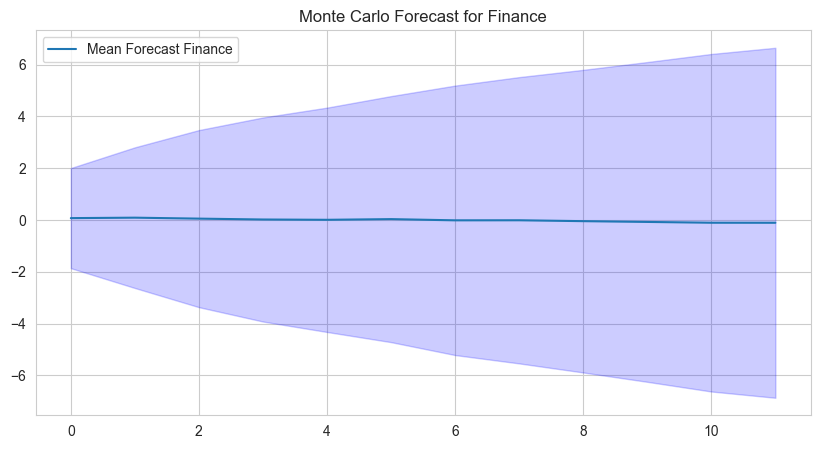

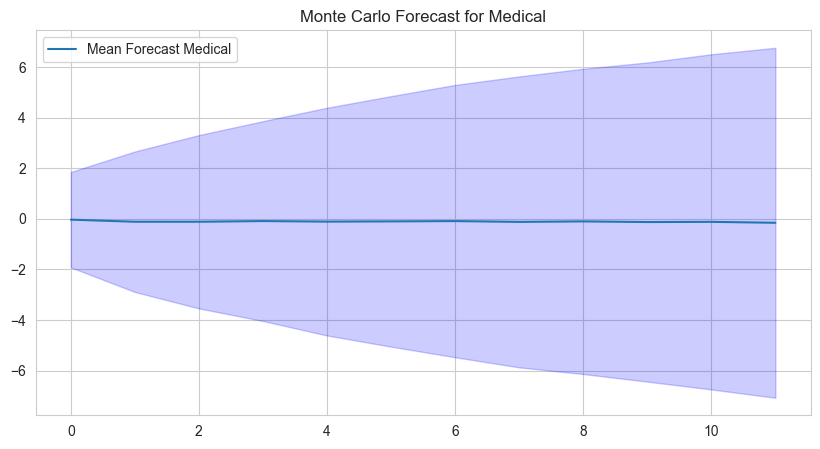

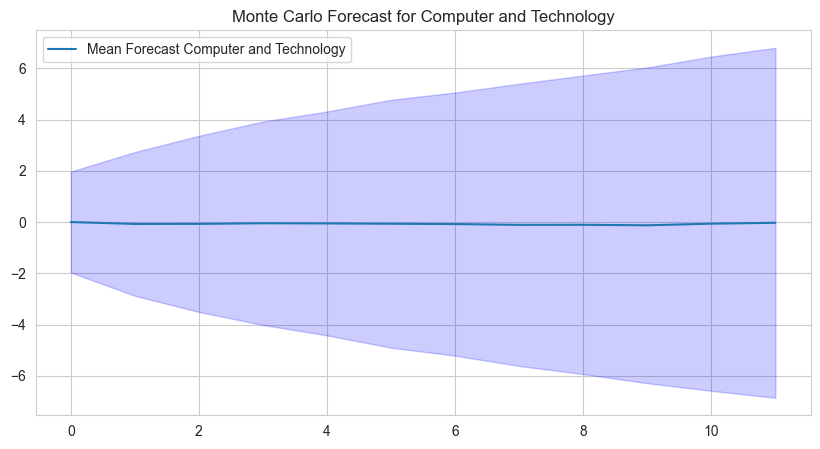

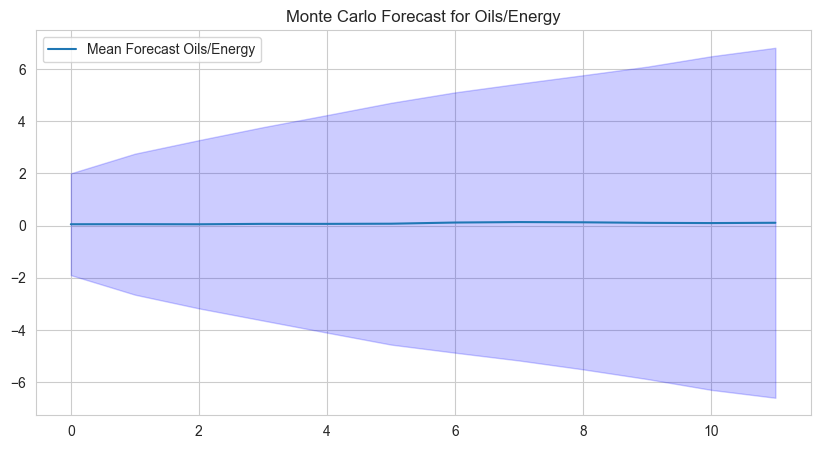

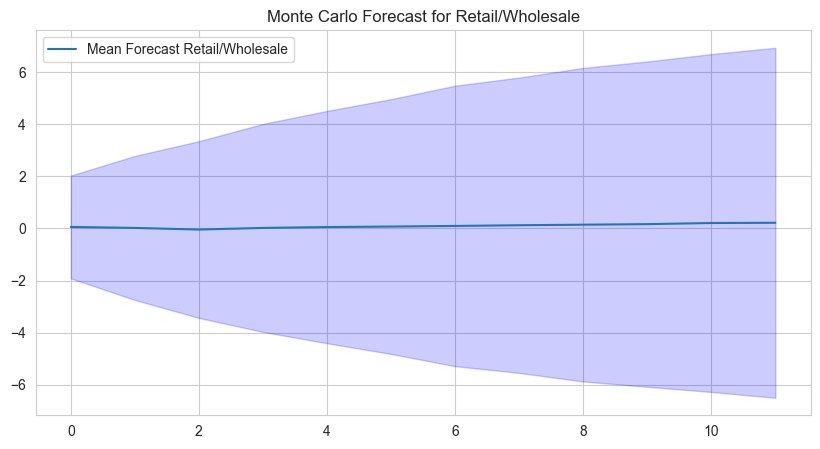

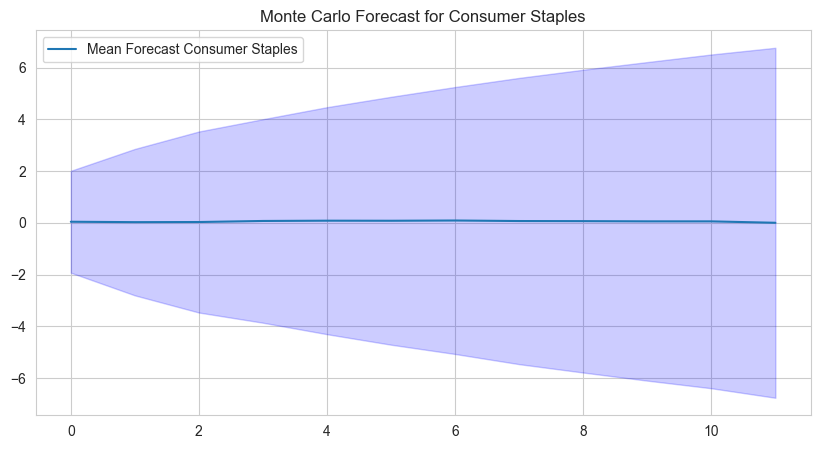

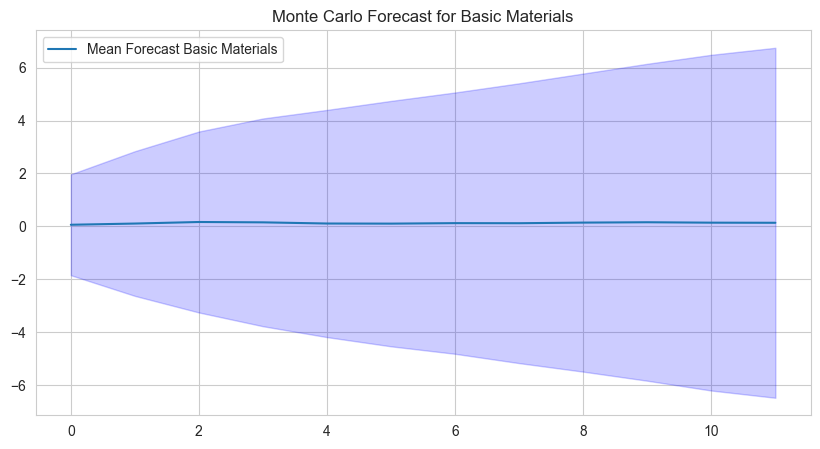

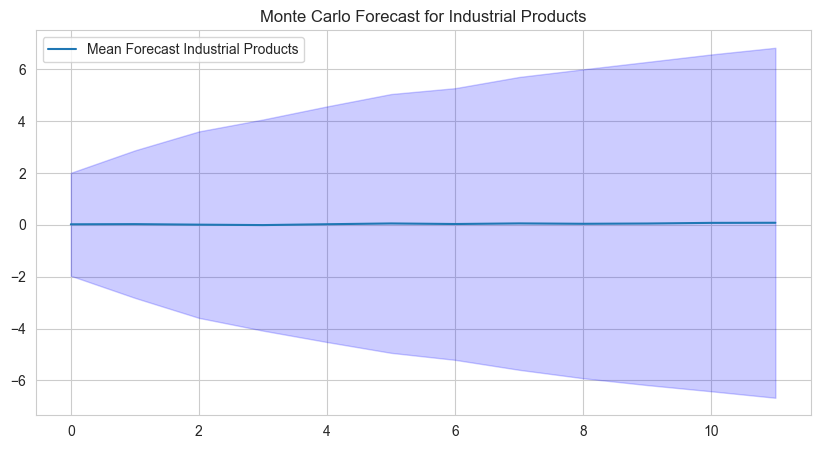

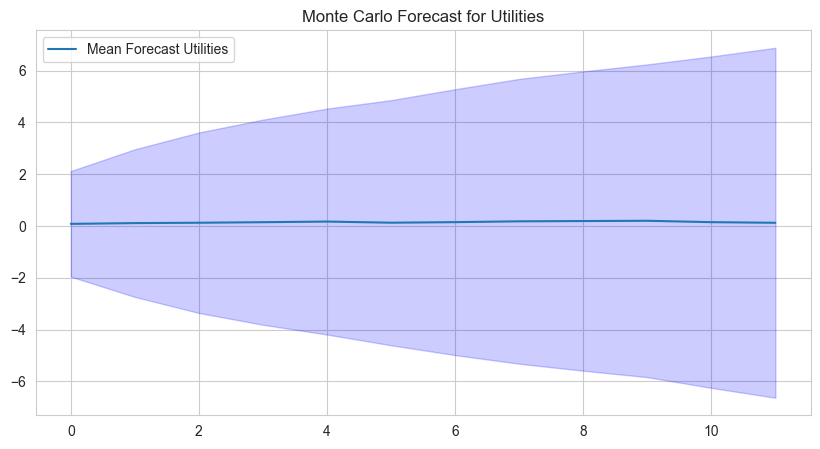

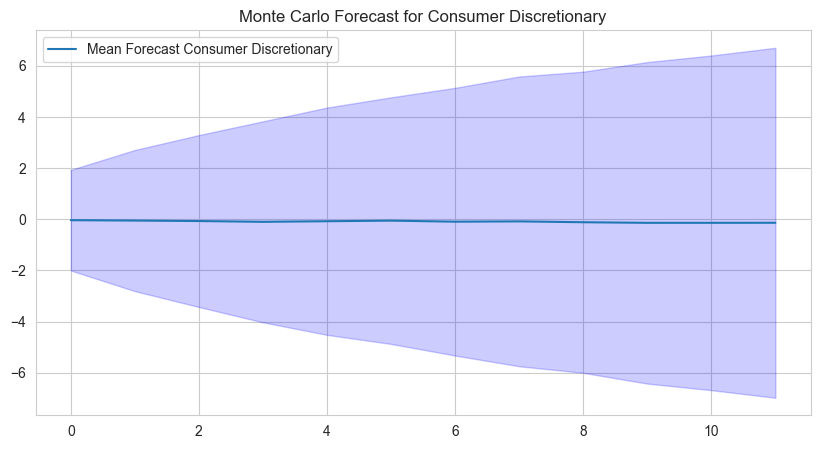

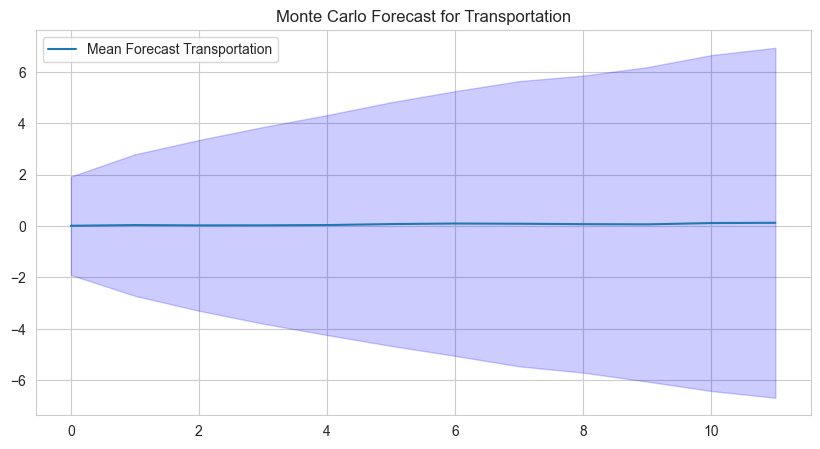

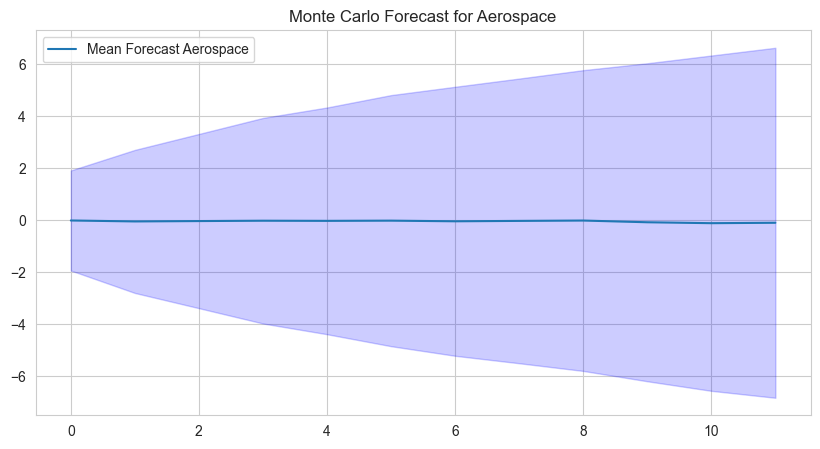

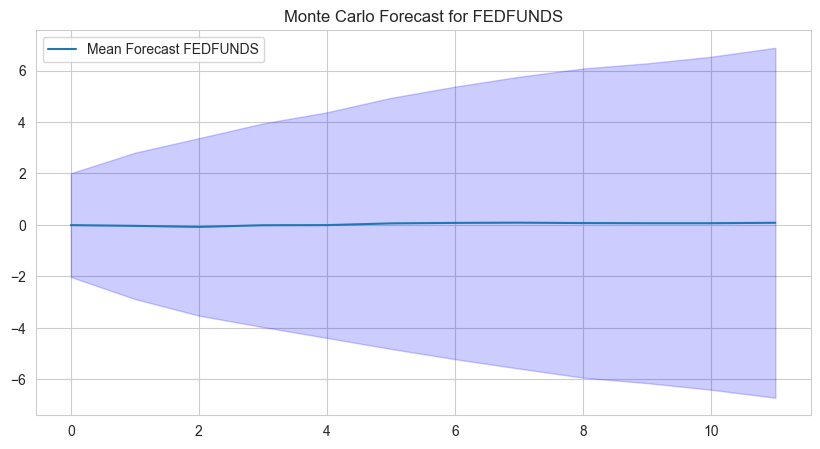

In [14]:

# Plots pour chaque secteur
for idx, sector in enumerate(aligned_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(mean_forecast[:, idx], label=f'Mean Forecast {sector}')
    plt.fill_between(range(forecast_horizon), 
                     mean_forecast[:, idx] - 1.96 * std_dev_forecast[:, idx], 
                     mean_forecast[:, idx] + 1.96 * std_dev_forecast[:, idx], color='b', alpha=0.2)
    plt.title(f'Monte Carlo Forecast for {sector}')
    plt.legend()
    plt.show()
